# Let's think about fines storage.  
Amanda Manaster  
*2019.07.02*  

**Condition 1:**  
Amount of entering sediment is *greater than* amount of exiting sediment.  

$dS_{f_{i}} = u*truck*L - q_s*t_s$  
$S_{f_{i+1}} = S_{f_{i}} + dS_{f_{i}}$  


**Condition 2:**  
Amount of entering sediment is *less than* amount of exiting sediment.  

$q_{s_{out}} = min(u*truck*L + S_{f_i}, q_s*t_s)$  
$ dS_{f_i} = u*truck*L - q_{s_{out}}$  
$S_{f_{i+1}} = S_{f_{i}} + dS_{f_{i}}$  



**where:**  
    &emsp;$S_f$ = storage of fine sediment in $m^2$  
    &emsp;$u$ = pumping of fines w/ each truck pass; $0.005 mm$  
    &emsp;$truck$ = # of truck passes; constant   
    &emsp;$L$ = representative length of road in $m$  
    &emsp;$t_s$ = storm duration in $s$  
    &emsp;$q_s$ = mean rate of sediment transport during a storm, assuming steady-state runoff in $m^2/s$   
    
       
**Gover's equation (Istanbulluoglu et al. 2002):**  
    &emsp;$q_s = \frac{10^{-4.348}}{(\rho_s*d_{50}^{0.811})}*(\tau-\tau_c)^{2.457}$  
    
    *Note: This equation is calibrated for sediments that are between 0.058 and 1.098 mm.*  

**more variables:**  
    &emsp;$\tau$ = shear stress  
    &emsp;$\tau_c$ = critical shear stress  
    &emsp;$\rho_w$ = density of water; $1000 kg/m^3$  
    &emsp;$g$ = gravity; $9.81 m/s^2$  
    &emsp;$H$ = depth of water   
    &emsp;$S$ = slope  
    &emsp;$\rho_s$ = density of sediment; $2650 kg/m^3$  
    &emsp;$r$ = runoff rate in $m/s$  
    &emsp;$d_{50}$ = median grain size of fines  
   

First, we'll import the necessary Python packages.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

Then, we'll initialize constants and empty lists.

In [2]:
L = 3.66
month = []
depth = []
rainfall = []
t = []
len_s = []
truck_pass = []

model_end = 4320 #hours

Now we can run our model. We calculate a "recovery" time, $T_b$, (i.e., the time between two storms) and a "storm" time, $T_r$, (i.e., the length of a storm.) $T_b$ is randomly generated from an exponential distribution centered around <span style="color:red">72 hours</span>. $T_r$ is randomly generated from an exponential distribution centered around <span style="color:red">0.85 hours </span> which is the average length of a storm in the PNW assuming:  

$\bar{T_r} = \frac{\bar{P}}{n_s * \bar{i}}$  

where:  
&emsp;$\bar{P} = 2540$ mm   
&emsp;$n_s = 100$ storms  
&emsp;$\bar{i} = 30$ mm/hr    

The model time step is $T_b + T_r$ which causes the time step to change during each loop.

Additionally, a rainfall intensity, $r$, is randomly sampled from an exponential distribution centered around <span style="color:red">30 mm/hr</span>, and each loop of the model appends a constant number of truck passes to an originally empty list.

In [3]:
np.random.seed(1)
time = 0
while time < model_end:
    truck = 0
    T_b = np.random.exponential(72)
    T_r = np.random.exponential(0.85)
    r = np.random.exponential(30)
    
    while (r<10) or (r>100):
        r = np.random.exponential(30)
    
    if T_b/24 >= 1:
        day = int(T_b/24)
        for num in range(0, day):
            truck += np.random.randint(0,10)
    else:
        truck = np.random.randint(0,5)
    
    len_s.append(T_r)
    depth.append(r*T_r)
    rainfall.append(r)
    t.append(time)
    truck_pass.append(truck)
    
    time += T_b + T_r

Because we have so many lists/arrays to work with, I create a Pandas dataframe for future calculations and visualizations with these data.

In [4]:
df = pd.DataFrame()

df['time'] = t
df['day'] = np.divide(t,24).astype('int64')
df['storm_depth'] = depth
df['rainfall_rate'] = rainfall
df['storm_length'] = len_s
df['truck_pass'] = truck_pass

day0 = datetime(2018, 10, 1)
df.set_index(pd.DatetimeIndex([day0+timedelta(hours=time) for time in df.time]), inplace=True)

df.head()

,time,day,storm_depth,rainfall_rate,storm_length,truck_pass
2018-10-01 00:00:00.000000,0.000000,0,11.696884,10.800383,1.083006,0
2018-10-02 15:56:04.656292,39.934627,1,2.228388,12.719294,0.175197,1
2018-10-02 23:05:07.666605,47.085463,1,16.014891,34.676391,0.461838,6
2018-10-05 07:16:20.658723,103.272405,4,33.649366,48.395031,0.695306,9
2018-10-06 22:51:15.360342,142.854267,5,1.813292,21.903831,0.082784,17


As discussed above, the model time step is variable. In order to have a daily time step instead, we resample the Pandas dataframe and give it a new name.

In [5]:
df2 = df.resample('D').mean().fillna(0)
df2['day'] = np.arange(0, len(df2), 1)
df2.head()

,time,day,storm_depth,rainfall_rate,storm_length,truck_pass
2018-10-01,0.000000,0,11.696884,10.800383,1.083006,0.0
2018-10-02,43.510045,1,9.121640,23.697843,0.318518,3.5
2018-10-03,0.000000,2,0.000000,0.000000,0.000000,0.0
2018-10-04,0.000000,3,0.000000,0.000000,0.000000,0.0
2018-10-05,103.272405,4,33.649366,48.395031,0.695306,9.0


Now, we can plot storm depth as a function of time for the entire 6 month time period.

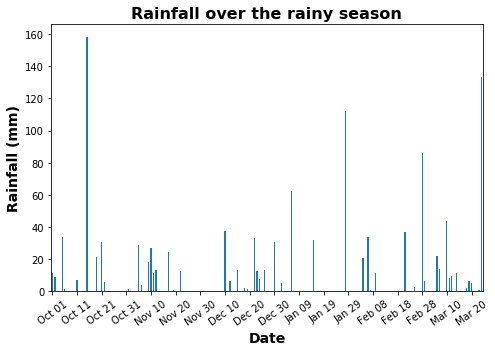

In [6]:
ticklabels = [item.strftime('%b %d') for item in df2.index[::10]]
fig, ax = plt.subplots(figsize=(7,5))
df2.plot.bar(y='storm_depth', ax=ax, legend=False)
plt.xlabel('Date', fontweight='bold', fontsize=14)
plt.ylabel('Rainfall (mm)', fontweight='bold', fontsize=14)
plt.title('Rainfall over the rainy season', fontweight='bold', fontsize=16)
plt.xticks(np.arange(0,10*len(ticklabels),10), ticklabels, rotation=35)
plt.tight_layout()
plt.savefig(r'C:\Users\Amanda\Desktop\Rainfall.png', dpi=300)
plt.show()

We can start to calculate other parameters, including shear stress, sediment transport rate, and, ultimately, the fine sediment storage.  
To calculate shear stress, we use: 
$$\tau = \rho_w*g*H*S$$
where H is the water depth calculated by:  
$$ H = {[\frac{n*q_o}{S^{1/2}}]}^{3/5}$$ 
This water depth calculation assumes uniform overland flow and that $q_o$ is rainfall rate multiplied by specific catchment area (i.e., $q_o = r*L$).

In [7]:
rho_w = 1000 #kg/m^3
rho_s = 2650 #kg/m^3
g = 9.81 #m/s^2
S = 0.058
tau_c = 0.110 #N/m^2; assuming d50 is approx. 0.0625 mm; value from https://pubs.usgs.gov/sir/2008/5093/table7.html
d50 = 6.25e-5 #m
u = 5.0e-6 #m
n = 0.02 #approx Manning's n value for overland flow

H = ((n*df.rainfall_rate*2.77778e-7*L)/S**(1/2))**(3/5)

df['shear_stress'] = rho_w*g*(H)*S

In [8]:
df['q_s'] = ((10**(-4.348))/(rho_s*d50**(0.811)))*(df.shear_stress-tau_c)**(2.457)
df.fillna(0, inplace=True)

df.head()

,time,day,storm_depth,rainfall_rate,storm_length,truck_pass,shear_stress,q_s
2018-10-01 00:00:00.000000,0.000000,0,11.696884,10.800383,1.083006,0,0.135225,5.147551e-09
2018-10-02 15:56:04.656292,39.934627,1,2.228388,12.719294,0.175197,1,0.149167,1.517370e-08
2018-10-02 23:05:07.666605,47.085463,1,16.014891,34.676391,0.461838,6,0.272279,4.987818e-07
2018-10-05 07:16:20.658723,103.272405,4,33.649366,48.395031,0.695306,9,0.332563,1.083900e-06
2018-10-06 22:51:15.360342,142.854267,5,1.813292,21.903831,0.082784,17,0.206684,1.397357e-07


In [9]:
df3 = df.resample('D').mean().fillna(0)
df3['day'] = np.arange(0, len(df3), 1)

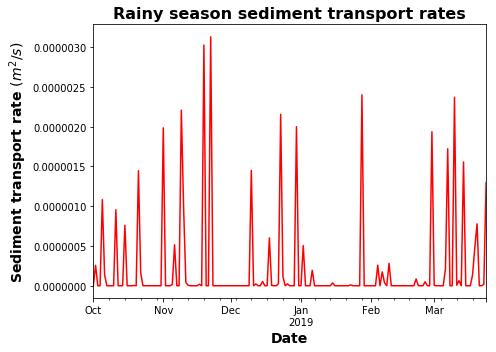

In [10]:
fig2, ax2 = plt.subplots(figsize=(7,5))
df3.plot(y='q_s', ax=ax2, color = 'r', legend=False)
plt.xlabel('Date', fontweight='bold', fontsize=14)
plt.ylabel(r'Sediment transport rate $(m^2/s)$', fontweight='bold', fontsize=14)
plt.title('Rainy season sediment transport rates', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.savefig(r'C:\Users\Amanda\Desktop\Sediment.png', dpi=300)
plt.show()

## Create loop that goes through model time:
1. Create storage term == 0 at t = 0
2. Is avail_sed > sed_transp?
    - If *yes*, **condition 1** applies:  
      Amount of entering sediment is *greater than* amount of exiting sediment.  
      $dS_{f_{i}} = u*truck*L - q_s*t_s$  
      $S_{f_{i+1}} = S_{f_{i}} + dS_{f_{i}}$   
      
    - If *no*, **condition 2** applies:  
      Amount of entering sediment is *less than* amount of exiting sediment.  
      $q_{s_{out}} = min(u*truck*L + S_{f_i}, q_s*t_s)$  
      $dS_{f_i} = u*truck*L - q_{s_{out}}$  
      $S_{f_{i+1}} = S_{f_{i}} + dS_{f_{i}}$  
      
      
3. Update storage term according to each condition

In [11]:
exit_sed = df.storm_length*3600*df.q_s
ent_sed = u*df.truck_pass*L
value = (ent_sed-exit_sed)


df['outgoing'] = exit_sed
df['incoming'] = ent_sed
df['value'] = value
df['condition'] = np.where(df.value > 0, 'Conditon 1', 'Condition 2')

In [17]:
df['q_s_out'] = np.zeros(len(df))
df['storage'] = np.zeros(len(df))
dsf = []
qs_out = []
leftover = np.zeros(len(df))

for i in range(0, len(df)):
    if df.value[i] < 0:
        if i ==0:
            qs_out.append(np.minimum(ent_sed[i], exit_sed[i]))
            dsf.append(ent_sed[i] - np.minimum(ent_sed[i], exit_sed[i]))
        else:
            qs_out.append(np.minimum(ent_sed[i]+leftover[i-1], exit_sed[i]))
            dsf.append(ent_sed[i] - np.minimum(ent_sed[i]+leftover[i-1], exit_sed[i]))
    else:
        qs_out.append(exit_sed[i])
        dsf.append(value[i])

    if i == 0:
        leftover[i] = dsf[i]
    else:
        leftover[i] = leftover[i-1] + dsf[i]
    
df.q_s_out = qs_out        
df.storage = leftover
df['dsf'] = dsf
df

,time,day,storm_depth,rainfall_rate,storm_length,truck_pass,shear_stress,q_s,outgoing,incoming,value,condition,q_s_out,storage,dsf
2018-10-01 00:00:00.000000,0.000000,0,11.696884,10.800383,1.083006,0,0.135225,5.147551e-09,2.006939e-05,0.000000,-2.006939e-05,Condition 2,0.000000e+00,0.000000e+00,0.000000e+00
2018-10-02 15:56:04.656292,39.934627,1,2.228388,12.719294,0.175197,1,0.149167,1.517370e-08,9.570215e-06,0.000018,8.729785e-06,Conditon 1,9.570215e-06,8.729785e-06,8.729785e-06
2018-10-02 23:05:07.666605,47.085463,1,16.014891,34.676391,0.461838,6,0.272279,4.987818e-07,8.292838e-04,0.000110,-7.194838e-04,Condition 2,1.185298e-04,5.082198e-21,-8.729785e-06
2018-10-05 07:16:20.658723,103.272405,4,33.649366,48.395031,0.695306,9,0.332563,1.083900e-06,2.713112e-03,0.000165,-2.548412e-03,Condition 2,1.647000e-04,5.082198e-21,0.000000e+00
2018-10-06 22:51:15.360342,142.854267,5,1.813292,21.903831,0.082784,17,0.206684,1.397357e-07,4.164448e-05,0.000311,2.694555e-04,Conditon 1,4.164448e-05,2.694555e-04,2.694555e-04
2018-10-11 19:48:58.280874,259.816189,10,9.990280,63.147089,0.158206,3,0.390127,1.907420e-06,1.086359e-03,0.000055,-1.031459e-03,Condition 2,3.243555e-04,0.000000e+00,-2.694555e-04
2018-10-11 22:50:33.802256,262.842723,10,4.627531,10.259064,0.451067,7,0.131117,3.325912e-09,5.400760e-06,0.000128,1.226992e-04,Conditon 1,5.400760e-06,1.226992e-04,1.226992e-04
2018-10-15 07:28:45.482902,343.479301,14,158.143824,41.369513,3.822714,25,0.302693,7.606947e-07,1.046851e-02,0.000458,-1.001101e-02,Condition 2,5.801992e-04,5.421011e-20,-1.226992e-04
2018-10-19 15:09:24.421280,447.156784,18,21.205905,10.427810,2.033592,7,0.132407,3.847440e-09,2.816684e-05,0.000128,9.993316e-05,Conditon 1,2.816684e-05,9.993316e-05,9.993316e-05
2018-10-21 11:57:33.873854,491.959409,20,47.189174,74.617362,0.632415,0,0.431219,2.669968e-06,6.078705e-03,0.000000,-6.078705e-03,Condition 2,9.993316e-05,0.000000e+00,-9.993316e-05


In [13]:
df4 = df.resample('H').mean().fillna(method='ffill')
df4['hour'] = np.arange(0, len(df4), 1)

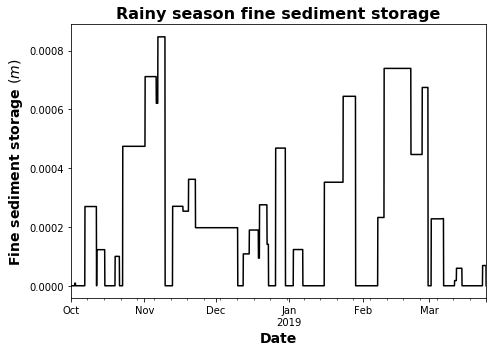

In [14]:
fig3, ax3 = plt.subplots(figsize=(7,5))
df4.plot(y='storage', ax=ax3, color = 'k', legend=False)
plt.xlabel('Date', fontweight='bold', fontsize=14)
plt.ylabel(r'Fine sediment storage $(m)$', fontweight='bold', fontsize=14)
plt.title('Rainy season fine sediment storage', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

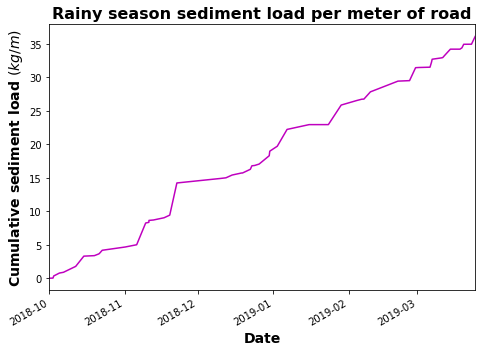

In [15]:
fig4, ax4 = plt.subplots(figsize=(7,5))
sed_cumsum_kg_m = df.q_s_out.cumsum()*rho_s
sed_cumsum_kg_m.plot(ax=ax4, color = 'm', legend=False)
plt.xlabel('Date', fontweight='bold', fontsize=14)
plt.ylabel(r'Cumulative sediment load $(kg/m)$', fontweight='bold', fontsize=14)
plt.title('Rainy season sediment load per meter of road', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
sed_sum_m2 = df.q_s_out.sum()
sed_sum_kg_m = sed_sum_m2*rho_s
sed_sum_kg_m

36.080279999999995